In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from pandas.io.json import json_normalize

# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '04b1ca0e-558c-48d0-ba28-fee796a82076'
resource_group = 'analytics2040c59b'
workspace_name = 'VitableML'

workspace = Workspace(subscription_id, resource_group, workspace_name)
parameterFilename = 'models/prod_quiz_parameter_recommender/source_files/vitableParameters.csv'
parameterList = np.genfromtxt(parameterFilename, delimiter=',', dtype='<U12')
sep_pt = '.'

sample_outcomes_filepath = "second_outcomes.csv"
previous_distribution_filepath = 'models/prod_quiz_parameter_recommender/source_files/vitableDistributionCurrent.csv'
new_distribution_filepath = "third_distribution"

target_variable = 0.0
N_parameters = len(parameterList)

update_distribution_weighting = 0.5
confidence_0p5_pt = 15.0
confidence_slope = 0.2

In [6]:
## update distribution
def update_distribution(target_variable_results, prior_distribution, confidence):
    
    target_variable_distribution = target_variable_results/np.mean(target_variable_results)*confidence/np.mean(confidence)
    #relative_distribution_difference = np.nan_to_num((target_variable_results - prior_distribution)/prior_distribution)#*confidence)
    new_distribution = prior_distribution*(1.0-update_distribution_weighting+update_distribution_weighting*target_variable_distribution)
    new_distribution = new_distribution/sum(new_distribution)

    return new_distribution

## confidence function

def confidence_sigmoid(vector):
    confidence_value = np.zeros(len(vector))

    for x in range(len(vector)):
        confidence_value[x] = 1.0/(1.0 + math.exp(-confidence_slope*(vector[x]-confidence_0p5_pt)))

    return confidence_value

def update_distribution_from_tracker_user_behaviour(offers_summary, accepts_summary, population_benefits, prior_distribution, new_distribution_id, parameters_vector):

    ## WE ESTIMATE HOW CONFIDENT WE ARE IN EACH OUTCOME BEING SIGNIFICANT
    confidence = confidence_sigmoid(offers_summary)
    print('Calculated confidence')
    
    ## WE UPDATE THE PREVIOUS DISTRIBUTION BASED ON THE EVENTS WE HAVE SEEN
    new_distribution = update_distribution(population_benefits, prior_distribution, confidence)
    print('Created new distribution')

    ## EXPORT NEW DISTRIBUTION
    distribution_save = new_distribution
    np.savetxt(sep_pt.join([new_distribution_id,'csv']), distribution_save, delimiter = ",", fmt='%s')

    return new_distribution 

def create_customer_outcomes_summary(parameterList,customer_array):

    N_parameters = len(parameterList)
    store_array = np.zeros([N_parameters,10])

    for i in range(N_parameters):
        split_parameter = parameterList[i].split("_")
        store_array[i,0] = int(split_parameter[0])
        store_array[i,1] = int(split_parameter[1])
        store_array[i,2] = int(split_parameter[2])
        #store_array[i,3] = int(split_parameter[3])
        #store_array[i,4] = int(split_parameter[4])

    N_customers = len(customer_array)


    store_array[:,[5,6,7,8,9]] = 0
    for n_customer in range(N_customers):
        for n_parameter in range(N_parameters):
            if int(customer_array[n_customer,1]) == store_array[n_parameter,0]:
                if int(customer_array[n_customer,2]) == store_array[n_parameter,1]:
                    if int(customer_array[n_customer,3]) == store_array[n_parameter,2]:
                        #if int(customer_array[n_customer,3]) == store_array[n_parameter,3]:
                        #    if int(customer_array[n_customer,4]) == store_array[n_parameter,4]:

                        store_array[n_parameter,5] = store_array[n_parameter,5] + 1 ## Someone accepted the recommendation

                        if int(customer_array[n_customer,5]) == 1:  ## Someone purchased the recommendation
                            store_array[n_parameter,6] = store_array[n_parameter,6] + 1
                            store_array[n_parameter,7] = store_array[n_parameter,7] + int(customer_array[n_customer,5])

    ## Store array 8 is average revenue per invoked recommendation 
    store_array[:,8] = store_array[:,7]/store_array[:,5]
    store_array = np.nan_to_num(store_array).copy()

    ## Pull out the total average revenue per invoked recommendation
    target_variable = np.sum(store_array[:,7])/np.sum(store_array[:,5]) 

    sample_distribution = store_array[:,5]/sum(store_array[:,5])

    # GET NUMBER OF OFFERS AND ACCEPTS FROM OUTCOMES
    new_distribution = update_distribution_from_tracker_user_behaviour(store_array[:,5], store_array[:,6], store_array[:,8], sample_distribution, new_distribution_filepath, parameterList)
    store_array[:,9] = new_distribution

    return store_array, target_variable

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


Calculated confidence
Created new distribution


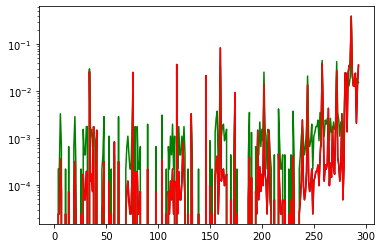

In [9]:

customer_array = np.array(pd.read_csv(sample_outcomes_filepath))

store_array, target_variable = create_customer_outcomes_summary(parameterList,customer_array)

## Compare distributions
previous_distribution = np.genfromtxt(previous_distribution_filepath, delimiter=',')
plt.plot(previous_distribution,'k')
plt.plot(store_array[:,5]/sum(store_array[:,5]),'g')
plt.plot(store_array[:,9],'r')
plt.yscale('log')
plt.show()


In [2]:
print('Hello')

Hello
